In [ ]:
# Install Keras Tuner (if not already installed)
!pip install keras-tuner

# Import required libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner import RandomSearch  # Import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters  # Import HyperParameters
from tensorflow.keras.applications import ResNet50  # Pre-trained model for transfer learning

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

<ipython-input-2-f1ef5f837b41>:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch  # Import RandomSearch


Mounted at /content/drive


In [ ]:
# Define dataset path
dataset_path = "/content/drive/My Drive/Research/cell_images/"
print("Dataset exists:", os.path.exists(dataset_path))

Dataset exists: True


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

class KerasClassifierWrapper:
    def __init__(self, model_path=None, build_fn=None, epochs=10, batch_size=32):
        self.model_path = model_path
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self._initialize_model()

    def _initialize_model(self):
        if self.model_path:
            # If a path is provided, load the model from the path
            self.model = load_model(self.model_path)
        elif self.build_fn:
            # Otherwise, build the model using the provided build_fn
            self.model = self.build_fn()
        if self.model:
            self.model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        else:
            print("Error: Model not initialized properly.")

    def fit(self, X, y):
        if self.model is None:
            raise ValueError("Model is not initialized properly.")
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size)

    def predict_proba(self, X):
        if self.model is None:
            raise ValueError("Model is not initialized properly.")
        return self.model.predict(X)



In [ ]:
# ✅ Define dataset
categories = ["Parasitized", "Uninfected"]
X, y = [], []
max_images = 10000 # Load 10000 images per class

for class_index, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_count = 0

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)

        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (128, 128))  # Resize to match CNN input shape
        X.append(img)
        y.append(class_index)

        image_count += 1
        if image_count >= max_images:
            break  # Stop after max_images per class

# Convert to NumPy arrays
X = np.array(X, dtype="float32") / 255.0  # Normalize
y = np.array(y)

print(f"✅ Successfully loaded {len(X)} images.")


✅ Successfully loaded 20000 images.


In [ ]:
# ✅ Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 16000, Testing samples: 4000


In [ ]:
from sklearn.model_selection import train_test_split

# Make sure dataset is loaded
if 'X' not in locals():
    print("Error: Dataset is not loaded. Run data loading cells first.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 🔹 Define the ImageDataGenerator for Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values between 0 and 1
    rotation_range=30,  # Random rotation between 0 and 30 degrees
    width_shift_range=0.2,  # Random width shift
    height_shift_range=0.2,  # Random height shift
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Zoom transformations
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill missing pixels with nearest values
)

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import keras_tuner as kt
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Dropout, Flatten, Dense, Input

# ✅ Hyperparameter tuning for CNN (Keras Tuner)
def build_cnn(hp):
    model = Sequential()
    model.add(Input(shape=(128, 128, 3)))  # Explicit input layer
    # Convolutional layers with hyperparameters
    for i in range(hp.Int('num_conv_layers', 2, 5)):  # Tunable number of convolution layers
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}', 64, 256, step=64),  # Tunable filters
            kernel_size=(3, 3),  # Kernel size fixed to (3,3)
            activation=None  # Activation function defined after Conv2D
        ))
        model.add(BatchNormalization())
        model.add(LeakyReLU())  # Using LeakyReLU activation
        model.add(MaxPooling2D(2, 2))  # Max pooling with a 2x2 window
        model.add(Dropout(rate=hp.Float('conv_dropout_rate', 0.2, 0.5, step=0.1)))  # Tunable dropout rate
    # Dense layer
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', 256, 1024, step=256), activation='relu', kernel_regularizer=l2(0.01)))  # Dense layer with L2 regularization
    model.add(Dropout(rate=hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))  # Tunable dropout for the dense layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    # Learning rate tuner
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])  # Tunable learning rate choices
    optimizer = Adam(learning_rate=learning_rate)  # Adam optimizer with tunable learning rate
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',  # Binary classification loss function
        metrics=['accuracy']  # Monitoring accuracy
    )
    return model

# 🔹 Calculate class weights (in case of class imbalance)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

# Initialize the Keras Tuner
cnn_tuner = kt.RandomSearch(
    build_cnn,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per trial
    directory='hyperparameter_tuning_cnn',
    project_name='malaria_cnn'
)

# 🔹 Perform hyperparameter tuning for CNN
cnn_tuner.search(datagen.flow(X_train, y_train, batch_size=16), epochs=10,
                 validation_data=(X_test, y_test), class_weight=class_weights)

# Free up memory after hyperparameter tuning
tf.keras.backend.clear_session()

# 🔹 Get the best hyperparameters for CNN
best_cnn_hps = cnn_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best CNN Hyperparameters: {best_cnn_hps}")

# 🔹 Build the CNN model with the best hyperparameters
best_cnn = cnn_tuner.hypermodel.build(best_cnn_hps)

# 🔹 Add Checkpoint Callback to Save Model Progress
checkpoint_path = "/content/drive/MyDrive/best_cnn_model.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_best_only=True,
                                      monitor='val_loss',
                                      mode='min')

# 🔹 Train the best CNN model with checkpointing and early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_cnn.fit(datagen.flow(X_train, y_train, batch_size=16),
             epochs=20,
             validation_data=(X_test, y_test),
             class_weight=class_weights,
             callbacks=[checkpoint_callback, early_stopping])  # Adding early stopping


Reloading Tuner from hyperparameter_tuning_cnn/malaria_cnn/tuner0.json
Best CNN Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f4538d42a90>
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6740 - loss: 1.8694

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1405s 1s/step - accuracy: 0.6741 - loss: 1.8685 - val_accuracy: 0.8988 - val_loss: 17.1583
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9110 - loss: 0.2959

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1356s 1s/step - accuracy: 0.9110 - loss: 0.2959 - val_accuracy: 0.9455 - val_loss: 11.3731
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1322s 1s/step - accuracy: 0.9165 - loss: 0.2741 - val_accuracy: 0.8560 - val_loss: 15.8141
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1336s 1s/step - accuracy: 0.9184 - loss: 0.2696 - val_accuracy: 0.8245 - val_loss: 23.2464
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1361s 1s/step - accuracy: 0.9234 - loss: 0.2578 - val_accuracy: 0.9452 - val_loss: 28.5684
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1343s 1s/step - accuracy: 0.9200 - loss: 0.2642 - val_accuracy: 0.9270 - val_loss: 36.1677
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1337s 1s/step - accuracy: 0.9218 - loss: 0.2651 - val_accuracy: 0.7653 - val_loss: 221.2051


In [ ]:
from sklearn.naive_bayes import GaussianNB
import joblib

# ✅ Define GNB
gnb = GaussianNB()

# ✅ Train GNB
gnb.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# ✅ Save the trained model to a file
joblib.dump(gnb, 'gnb_model.pkl')  # Save the model to disk


['gnb_model.pkl']

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras.models import Sequential

# ✅ RCNN Model Build Function (with optimizer parameter)
def build_rcnn(hp):
    model = Sequential()
    # Example RCNN architecture (modify based on your actual design)
    for i in range(hp.Int('num_conv_layers', 2, 5)):  # Variable number of convolution layers
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}', 64, 256, step=64),  # Tunable filters
            kernel_size=(3, 3),  # Kernel size fixed to (3, 3)
            activation=None,  # Activation function defined later
            input_shape=(128, 128, 3) if i == 0 else None  # Input shape for the first layer only
        ))
        model.add(BatchNormalization())
        model.add(LeakyReLU())  # LeakyReLU activation function
        model.add(MaxPooling2D(2, 2))  # MaxPooling
        model.add(Dropout(rate=hp.Float('conv_dropout_rate', 0.2, 0.5, step=0.1)))  # Tunable dropout
    model.add(Flatten())  # Flatten layer for fully connected
    model.add(Dense(units=hp.Int('dense_units', 256, 1024, step=256), activation='relu', kernel_regularizer=l2(0.01)))  # Dense layer with L2 regularization
    model.add(Dropout(rate=hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))  # Tunable dropout for dense layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    # Optimizer selection with tunable learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])  # Tunable learning rate
    optimizer = Adam(learning_rate=learning_rate)  # Adam optimizer
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',  # Binary cross-entropy loss function
        metrics=['accuracy']  # Monitoring accuracy
    )
    return model
# ✅ Hyperparameter tuning for RCNN
rcnn_tuner = kt.RandomSearch(
    build_rcnn,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='hyperparameter_tuning_rcnn',
    project_name='malaria_rcnn'
)

# 🔹 Calculate class weights (in case of class imbalance)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

# 🔹 Perform hyperparameter tuning for RCNN (fix the tuner reference to rcnn_tuner)
rcnn_tuner.search(datagen.flow(X_train, y_train, batch_size=16), epochs=10,
                  validation_data=(X_test, y_test), class_weight=class_weights)

# Free up memory after hyperparameter tuning
tf.keras.backend.clear_session()

# 🔹 Get the best hyperparameters for RCNN
best_rcnn_hps = rcnn_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best RCNN Hyperparameters: {best_rcnn_hps}")

# 🔹 Build the RCNN model with the best hyperparameters
best_rcnn = rcnn_tuner.hypermodel.build(best_rcnn_hps)

# 🔹 Add Checkpoint Callback to Save Model Progress
checkpoint_path = "/content/drive/MyDrive/best_rcnn_model.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_best_only=True,
                                      monitor='val_loss',
                                      mode='min')

# 🔹 Train the best RCNN model with checkpointing and early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_rcnn.fit(datagen.flow(X_train, y_train, batch_size=16),
              epochs=20,
              validation_data=(X_test, y_test),
              class_weight=class_weights,
              callbacks=[checkpoint_callback, early_stopping])  # Adding early stopping


Reloading Tuner from hyperparameter_tuning_rcnn/malaria_rcnn/tuner0.json
Best RCNN Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f450b730090>


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5925 - loss: 6.1811

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2458s 2s/step - accuracy: 0.5925 - loss: 6.1776 - val_accuracy: 0.7035 - val_loss: 60.0448
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2542s 3s/step - accuracy: 0.7233 - loss: 0.7104 - val_accuracy: 0.5238 - val_loss: 66.9299
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8490 - loss: 0.6294

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2621s 3s/step - accuracy: 0.8490 - loss: 0.6294 - val_accuracy: 0.6050 - val_loss: 39.6133
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8667 - loss: 0.5880

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2594s 3s/step - accuracy: 0.8667 - loss: 0.5880 - val_accuracy: 0.8528 - val_loss: 39.5828
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2470s 2s/step - accuracy: 0.8776 - loss: 0.5637 - val_accuracy: 0.5107 - val_loss: 81.6997
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2485s 2s/step - accuracy: 0.8806 - loss: 0.5648 - val_accuracy: 0.7818 - val_loss: 61.9217
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8823 - loss: 0.5624

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2580s 3s/step - accuracy: 0.8823 - loss: 0.5624 - val_accuracy: 0.8110 - val_loss: 20.5716
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2548s 3s/step - accuracy: 0.8927 - loss: 0.5422 - val_accuracy: 0.5178 - val_loss: 78.2660
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2561s 3s/step - accuracy: 0.8895 - loss: 0.5448 - val_accuracy: 0.8658 - val_loss: 33.7772
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2605s 3s/step - accuracy: 0.8885 - loss: 0.5575 - val_accuracy: 0.8167 - val_loss: 20.9698
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2586s 3s/step - accuracy: 0.8878 - loss: 0.5573 - val_accuracy: 0.8997 - val_loss: 32.8197
Epoch 12/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2578s 3s/step - accuracy: 0.8920 - loss: 0.5427 - val_accuracy: 0.8982 - val_loss: 32.0532


In [ ]:
# Install Keras Tuner (if not already installed)
!pip install keras-tuner
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
import keras_tuner as kt
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to range [0, 1]
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in newly created pixels after transformations
)

# ✅ Define the Transfer Learning model
def build_transfer_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    # Unfreeze the last few layers
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=256, max_value=1024, step=256), activation='relu'),  # ✅ Tunable Dense Layer
        Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)),  # ✅ Tunable Dropout
        Dense(1, activation='sigmoid')
    ])

    # ✅ Tunable Learning Rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Calculate class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}
# Free up memory before starting hyperparameter tuning
tf.keras.backend.clear_session()
# Add Checkpoint callback to save model progress
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',  # File path to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # Minimize validation loss
    verbose=1
)

# Add EarlyStopping callback to stop training when validation loss stops improving
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Stop after 3 epochs with no improvement
    mode='min',  # Minimize validation loss
    verbose=1
)

# Perform hyperparameter tuning
transfer_tuner = kt.RandomSearch(
    build_transfer_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='hyperparameter_tuning_transfer',
    project_name='malaria_transfer'
)

# Perform hyperparameter tuning for Transfer Learning
transfer_tuner.search(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=10,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Add callbacks to tuning
)

# Free up memory after hyperparameter tuning
tf.keras.backend.clear_session()

# Get the best hyperparameters for the Transfer Learning model
best_transfer_hps = transfer_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Transfer Learning Hyperparameters: {best_transfer_hps}")

# Build the Transfer Learning model with the best hyperparameters
best_transfer_model = transfer_tuner.hypermodel.build(best_transfer_hps)

# Train the best Transfer Learning model with callbacks
best_transfer_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=20,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Add callbacks to training
)

NameError: name 'y_train' is not defined

In [ ]:
transfer_model.save('/content/drive/MyDrive/best_transfer_model.h5')


In [ ]:
from tensorflow.keras.models import load_model
transfer_model = load_model('/content/drive/MyDrive/best_transfer_model.h5')
print("tranfer model loaded successfully")


tranfer model loaded successfully


In [ ]:
# Install Keras Tuner (if not already installed)
!pip install keras-tuner
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load pre-trained model (VGG16 as an example)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers for transfer learning
transfer_model = models.Sequential()
transfer_model.add(base_model)
transfer_model.add(layers.GlobalAveragePooling2D())
transfer_model.add(layers.Dense(1024, activation='relu'))
transfer_model.add(layers.Dense(1, activation='sigmoid'))  # Change as per your dataset (binary or categorical)

# Freeze the layers of the pre-trained model to retain its learned features
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
transfer_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
transfer_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Save the model after training
transfer_model.save('/content/drive/MyDrive/best_transfer_model.h5')
print("✅ Transfer Model Trained and Saved Successfully")


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 648s 1s/step - accuracy: 0.8204 - loss: 0.3902 - val_accuracy: 0.9195 - val_loss: 0.2136
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.9222 - loss: 0.2020 - val_accuracy: 0.9252 - val_loss: 0.1959
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 635s 1s/step - accuracy: 0.9288 - loss: 0.1867 - val_accuracy: 0.9298 - val_loss: 0.1864
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 635s 1s/step - accuracy: 0.9262 - loss: 0.1972 - val_accuracy: 0.9305 - val_loss: 0.1859
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 638s 1s/step - accuracy: 0.9356 - loss: 0.1663 - val_accuracy: 0.9285 - val_loss: 0.1887
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - accuracy: 0.9352 - loss: 0.1672 - val_accuracy: 0.9210 - val_loss: 0.2052
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 641s 1s/step - accuracy: 0.9347 - loss: 0.1672 - val_accuracy: 0.9277 - val_loss: 0.1878
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.9297 - loss: 0.1788 - val_accu

✅ Transfer Model Trained and Saved Successfully


In [ ]:
from tensorflow.keras.models import load_model

# Load saved models
cnn_model_path = '/content/drive/MyDrive/best_cnn_model.h5'
rcnn_model_path = '/content/drive/MyDrive/best_rcnn_model.h5'

cnn_model = load_model(cnn_model_path)
rcnn_model = load_model(rcnn_model_path)

print("✅ CNN,RCNN and Transfer Models Loaded Successfully")


✅ CNN,RCNN and Transfer Models Loaded Successfully


In [ ]:
# ✅ Create model wrappers
cnn_wrapper = KerasClassifierWrapper(
    build_fn=lambda: build_cnn(best_cnn_hps),  # Remove optimizer argument
    epochs=10,
    batch_size=16
)

rcnn_wrapper = KerasClassifierWrapper(
    build_fn=lambda: build_rcnn(best_rcnn),  # Remove optimizer argument
    epochs=10,
    batch_size=16
)

transfer_wrapper = KerasClassifierWrapper(
    build_fn=lambda: build_transfer_model(best_transfer_hps),  # Remove optimizer argument
    epochs=10,
    batch_size=16
)

gnb = GaussianNB()

In [ ]:
# Load pre-trained models from their paths
best_cnn = load_model("/content/drive/MyDrive/best_cnn_model.h5")
best_rcnn = load_model("/content/drive/MyDrive/best_rcnn_model.h5")
best_transfer = load_model("/content/drive/MyDrive/best_transfer_model.h5")

# Initialize the wrappers with the loaded models
cnn_wrapper = KerasClassifierWrapper(
    model_path="/content/drive/MyDrive/best_cnn_model.h5",
    epochs=0,
    batch_size=16
)

rcnn_wrapper = KerasClassifierWrapper(
    model_path="/content/drive/MyDrive/best_rcnn_model.h5",
    epochs=10,
    batch_size=16
)

transfer_wrapper = KerasClassifierWrapper(
    model_path="/content/drive/MyDrive/best_transfer_model.h5",
    epochs=0,
    batch_size=16
)

# Ensure models are loaded and compiled properly
print("CNN model initialized successfully:", cnn_wrapper.model is not None)
print("RCNN model initialized successfully:", rcnn_wrapper.model is not None)
print("Transfer Learning model initialized successfully:", transfer_wrapper.model is not None)

# Now, you should be able to generate predictions
cnn_probs_train = cnn_wrapper.predict_proba(X_train)[:, 0]
cnn_probs_test = cnn_wrapper.predict_proba(X_test)[:, 0]

rcnn_probs_train = rcnn_wrapper.predict_proba(X_train)[:, 0]
transfer_probs_train = transfer_wrapper.predict_proba(X_train)[:, 0]

# Generate meta-features for stacking
meta_features_train = np.column_stack((cnn_probs_train, rcnn_probs_train, transfer_probs_train))
# Train meta-learner
meta_learner = LogisticRegression()
meta_learner.fit(meta_features_train, y_train)
# Generate meta-features for testing
cnn_probs_test = cnn_wrapper.predict_proba(X_test)[:, 0]
rcnn_probs_test = rcnn_wrapper.predict_proba(X_test)[:, 0]
transfer_probs_test = transfer_wrapper.predict_proba(X_test)[:, 0]
meta_features_test = np.column_stack((cnn_probs_test, rcnn_probs_test, transfer_probs_test))
# Meta-learner makes final predictions
y_pred_stack = meta_learner.predict(meta_features_test)
# Evaluate Model Stacking Performance
print("Stacked Model Performance:")
print(classification_report(y_test, y_pred_stack))

CNN model initialized successfully: True
RCNN model initialized successfully: True
Transfer Learning model initialized successfully: True
500/500 ━━━━━━━━━━━━━━━━━━━━ 257s 513ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 512ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 238s 475ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 513ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 483ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step
Stacked Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2019
           1       0.94      0.96      0.95      1981

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, title):
    """Plots a confusion matrix using seaborn heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 471ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step
CNN Model Performance:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2019
           1       0.95      0.94      0.94      1981

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



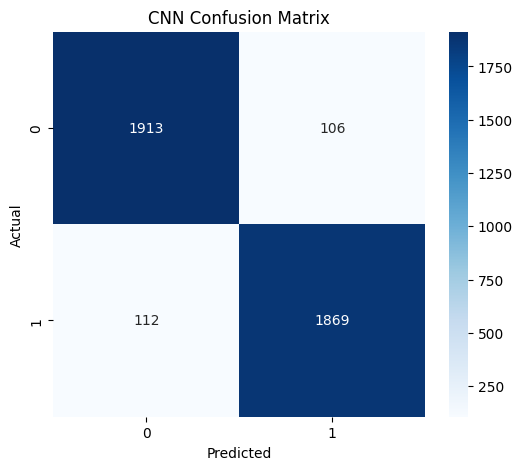

RCNN Model Performance:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      2019
           1       0.87      0.73      0.79      1981

    accuracy                           0.81      4000
   macro avg       0.82      0.81      0.81      4000
weighted avg       0.82      0.81      0.81      4000



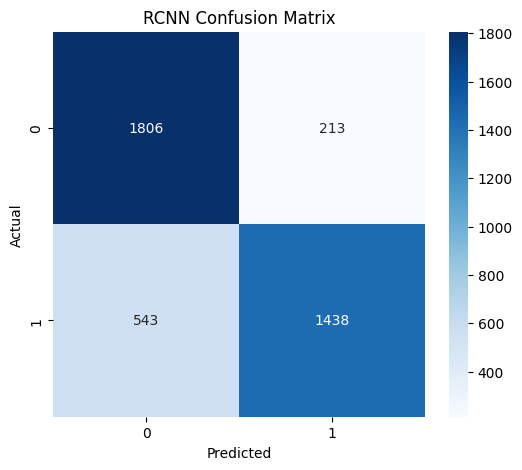

Transfer Learning Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      2019
           1       0.87      0.98      0.92      1981

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



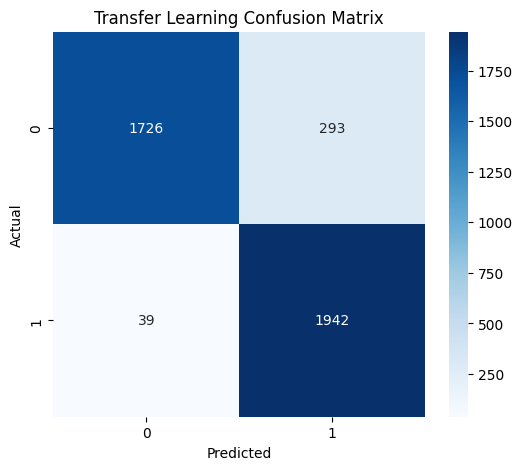

GNB Model Performance:
              precision    recall  f1-score   support

           0       0.67      0.47      0.55      2019
           1       0.59      0.77      0.66      1981

    accuracy                           0.62      4000
   macro avg       0.63      0.62      0.61      4000
weighted avg       0.63      0.62      0.61      4000



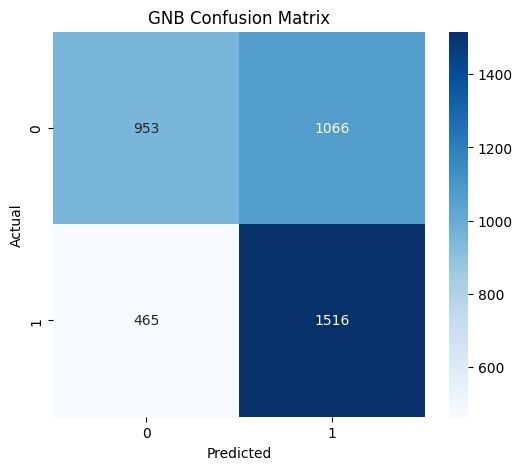

Stacked Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2019
           1       0.94      0.96      0.95      1981

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



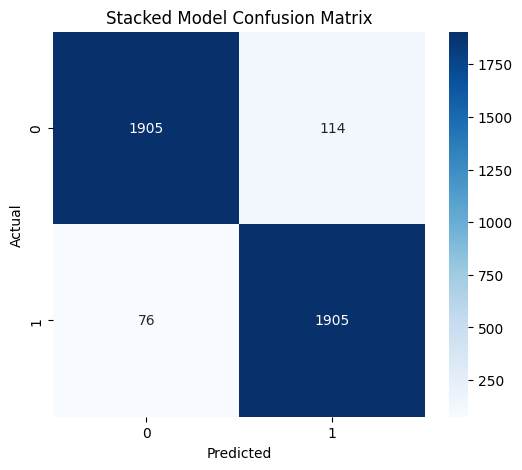

125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 504ms/step


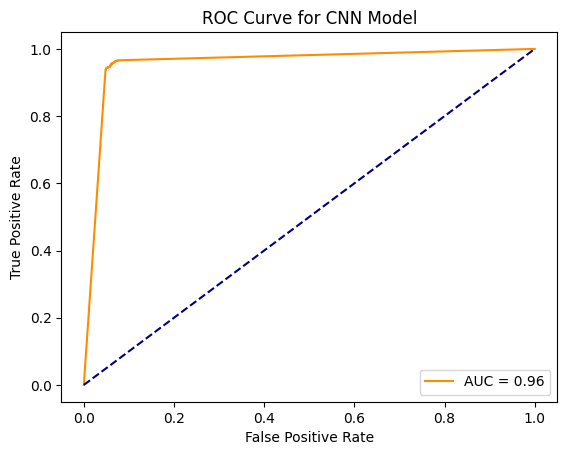

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
# Convert predicted probabilities to binary labels
# Convert predicted probabilities to binary labels using predict_proba
y_pred_cnn = (cnn_wrapper.predict_proba(X_test) > 0.5).astype(int)
y_pred_rcnn = (rcnn_wrapper.predict_proba(X_test) > 0.5).astype(int)
y_pred_transfer = (transfer_wrapper.predict_proba(X_test) > 0.5).astype(int)
# GNB already predicts discrete labels, so no need for thresholding
y_pred_gnb = gnb.predict(X_test.reshape(X_test.shape[0], -1))
# Stacked model predictions (if required)
y_pred_stack = meta_learner.predict(meta_features_test)
# Confusion Matrix for CNN
print("CNN Model Performance:")
print(classification_report(y_test, y_pred_cnn))
plot_confusion_matrix(y_test, y_pred_cnn, "CNN Confusion Matrix")

# Confusion Matrix for RCNN
print("RCNN Model Performance:")
print(classification_report(y_test, y_pred_rcnn))
plot_confusion_matrix(y_test, y_pred_rcnn, "RCNN Confusion Matrix")

# Confusion Matrix for Transfer Learning Model
print("Transfer Learning Model Performance:")
print(classification_report(y_test, y_pred_transfer))
plot_confusion_matrix(y_test, y_pred_transfer, "Transfer Learning Confusion Matrix")

# Confusion Matrix for GNB
print("GNB Model Performance:")
print(classification_report(y_test, y_pred_gnb))
plot_confusion_matrix(y_test, y_pred_gnb, "GNB Confusion Matrix")

# Confusion Matrix for Stacked Model
print("Stacked Model Performance:")
print(classification_report(y_test, y_pred_stack))
plot_confusion_matrix(y_test, y_pred_stack, "Stacked Model Confusion Matrix")

# ✅ Get predicted probabilities for CNN model
y_probs = cnn_wrapper.predict_proba(X_test)
y_probs = y_probs.flatten() if y_probs.shape[1] == 1 else y_probs[:, 1]  # Adjust based on sigmoid/softmax

# ✅ Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# ✅ Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CNN Model")
plt.legend()
plt.show()
